<a href="https://colab.research.google.com/github/sunandhini96/ERA_S7/blob/main/ERA1S7Model_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Model 2 :
Dataset : MNIST
Applied : for model_1 + dropout + image augmentation
(to improve performance -> dropout , image augmentation -> improving the training)

In [1]:
!git clone "https://github.com/katipallyvig8899/ERA_7"

Cloning into 'ERA_7'...
remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 9 (delta 0), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (9/9), 254.82 KiB | 2.63 MiB/s, done.


In [2]:
cd /content/ERA_7

/content/ERA_7


In [3]:
pwd

'/content/ERA_7'

In [4]:
!python model.py

In [5]:
from model import *

# Import Libraries

In [6]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise.


In [7]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values.
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [8]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

100%|██████████| 9912422/9912422 [00:00<00:00, 98352604.30it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 38726244.83it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 23177977.88it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 5779893.44it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



# Dataloader Arguments & Test/Train Dataloaders


In [9]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=64, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=32)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


# Summary of the model

In [10]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Model_2().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 12, 26, 26]             108
              ReLU-2           [-1, 12, 26, 26]               0
       BatchNorm2d-3           [-1, 12, 26, 26]              24
           Dropout-4           [-1, 12, 26, 26]               0
            Conv2d-5           [-1, 16, 24, 24]           1,728
              ReLU-6           [-1, 16, 24, 24]               0
       BatchNorm2d-7           [-1, 16, 24, 24]              32
           Dropout-8           [-1, 16, 24, 24]               0
            Conv2d-9           [-1, 10, 24, 24]             160
        MaxPool2d-10           [-1, 10, 12, 12]               0
           Conv2d-11           [-1, 12, 10, 10]           1,080
             ReLU-12           [-1, 12, 10, 10]               0
      BatchNorm2d-13           [-1, 12, 10, 10]              24
          Dropout-14           [-1

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs.

Let's write train and test functions

In [11]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

In [12]:
from torch.optim.lr_scheduler import StepLR

model =  Model_2().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=6, gamma=0.1)


EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    #scheduler.step()
    test(model, device, test_loader)

EPOCH: 0


Loss=0.12242922931909561 Batch_id=937 Accuracy=89.67: 100%|██████████| 938/938 [00:53<00:00, 17.56it/s]



Test set: Average loss: 0.0684, Accuracy: 9799/10000 (97.99%)

EPOCH: 1


Loss=0.06301453709602356 Batch_id=937 Accuracy=97.40: 100%|██████████| 938/938 [00:49<00:00, 18.90it/s]



Test set: Average loss: 0.0421, Accuracy: 9858/10000 (98.58%)

EPOCH: 2


Loss=0.022558171302080154 Batch_id=937 Accuracy=97.73: 100%|██████████| 938/938 [00:49<00:00, 19.10it/s]



Test set: Average loss: 0.0437, Accuracy: 9850/10000 (98.50%)

EPOCH: 3


Loss=0.007890741340816021 Batch_id=937 Accuracy=98.09: 100%|██████████| 938/938 [00:47<00:00, 19.73it/s]



Test set: Average loss: 0.0329, Accuracy: 9890/10000 (98.90%)

EPOCH: 4


Loss=0.010708306916058064 Batch_id=937 Accuracy=98.19: 100%|██████████| 938/938 [00:48<00:00, 19.28it/s]



Test set: Average loss: 0.0350, Accuracy: 9890/10000 (98.90%)

EPOCH: 5


Loss=0.05916133150458336 Batch_id=937 Accuracy=98.42: 100%|██████████| 938/938 [00:47<00:00, 19.73it/s]



Test set: Average loss: 0.0316, Accuracy: 9908/10000 (99.08%)

EPOCH: 6


Loss=0.012666337192058563 Batch_id=937 Accuracy=98.35: 100%|██████████| 938/938 [00:48<00:00, 19.23it/s]



Test set: Average loss: 0.0312, Accuracy: 9908/10000 (99.08%)

EPOCH: 7


Loss=0.03272470086812973 Batch_id=937 Accuracy=98.56: 100%|██████████| 938/938 [00:50<00:00, 18.62it/s]



Test set: Average loss: 0.0235, Accuracy: 9931/10000 (99.31%)

EPOCH: 8


Loss=0.1013830378651619 Batch_id=937 Accuracy=98.51: 100%|██████████| 938/938 [00:47<00:00, 19.54it/s]



Test set: Average loss: 0.0228, Accuracy: 9933/10000 (99.33%)

EPOCH: 9


Loss=0.00794896949082613 Batch_id=937 Accuracy=98.48: 100%|██████████| 938/938 [00:47<00:00, 19.79it/s]



Test set: Average loss: 0.0265, Accuracy: 9917/10000 (99.17%)

EPOCH: 10


Loss=0.004201823379844427 Batch_id=937 Accuracy=98.54: 100%|██████████| 938/938 [00:48<00:00, 19.24it/s]



Test set: Average loss: 0.0214, Accuracy: 9942/10000 (99.42%)

EPOCH: 11


Loss=0.03102811798453331 Batch_id=937 Accuracy=98.67: 100%|██████████| 938/938 [00:48<00:00, 19.43it/s]



Test set: Average loss: 0.0225, Accuracy: 9935/10000 (99.35%)

EPOCH: 12


Loss=0.023701343685388565 Batch_id=937 Accuracy=98.75: 100%|██████████| 938/938 [00:48<00:00, 19.35it/s]



Test set: Average loss: 0.0205, Accuracy: 9946/10000 (99.46%)

EPOCH: 13


Loss=0.0055982805788517 Batch_id=937 Accuracy=98.72: 100%|██████████| 938/938 [00:49<00:00, 18.80it/s]



Test set: Average loss: 0.0228, Accuracy: 9934/10000 (99.34%)

EPOCH: 14


Loss=0.01382297370582819 Batch_id=937 Accuracy=98.76: 100%|██████████| 938/938 [00:48<00:00, 19.29it/s]



Test set: Average loss: 0.0194, Accuracy: 9948/10000 (99.48%)



# Let's Train and test our model

This time let's add a scheduler for out LR.

Text(0.5, 1.0, 'Test Accuracy')

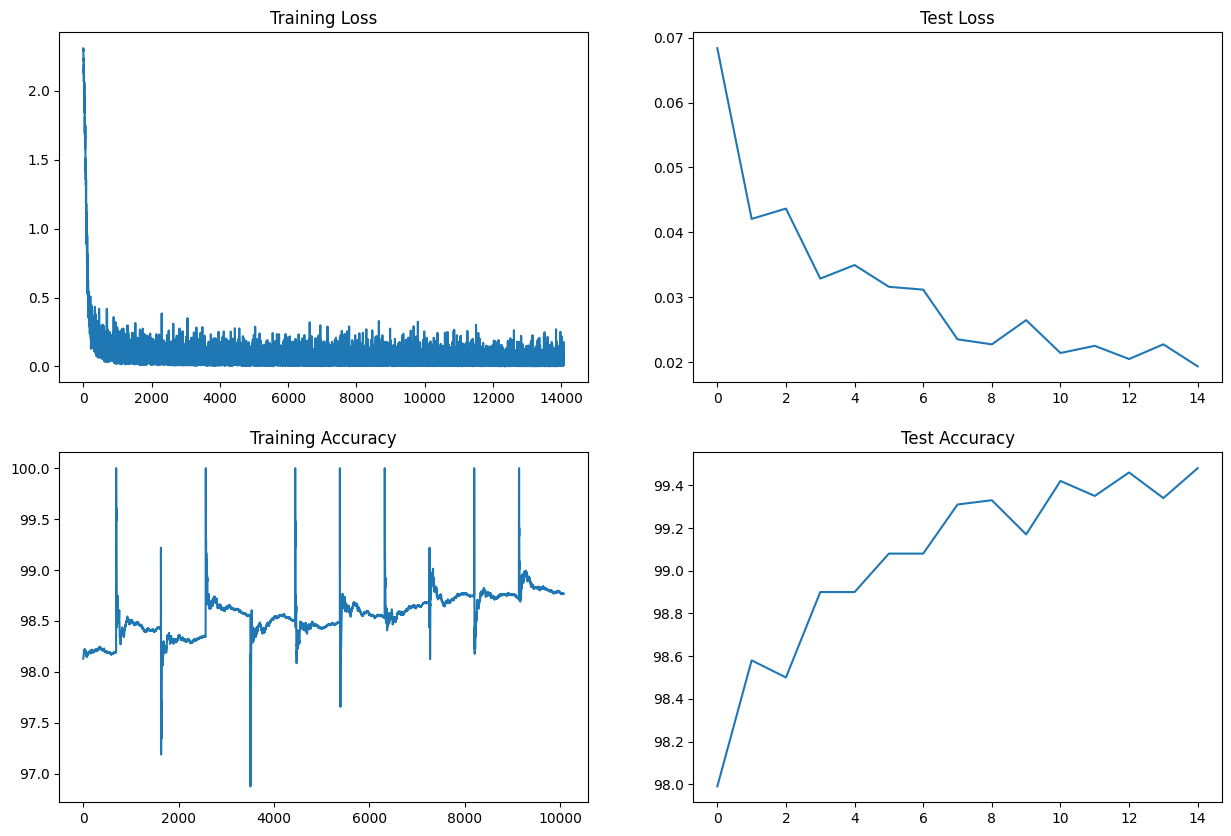

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2,2,figsize=(15,10))
t=[t.cpu().item() for t in train_losses]
axs[0, 0].plot(t)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

## Target:
-> We added dropout and image augmentation to improve performance and for better training. To avoid overfitting we applied dropout.
## Results:
-> Parameters: 7.7k

-> Best Train Accuracy: 98.76

-> Best Test Accuracy: 99.48
  